In [28]:
from shared.ingest import download_default_s3
download_default_s3()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [30]:
orders = pd.read_csv('tempdata/olist_orders_dataset.csv')
datecols = orders.loc[:,'order_purchase_timestamp':].columns
for col in datecols:
    orders[col] = pd.to_datetime(orders[col])

<AxesSubplot:>

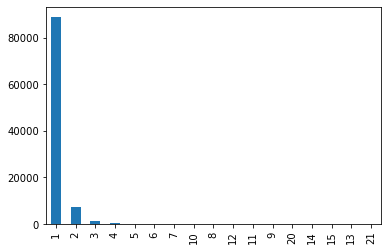

In [31]:
items = pd.read_csv('tempdata/olist_order_items_dataset.csv')
items.groupby('order_id')['order_item_id'].count().value_counts().plot(kind='bar')

We have relatively purchases with multiple items. Thus, we can treat each item purchase as an individual purchase.

<AxesSubplot:xlabel='order_purchase_timestamp'>

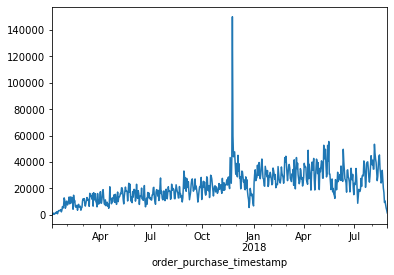

In [32]:
delivered = items.merge(orders[orders['order_status'] == 'delivered'], on='order_id')
products = pd.read_csv('tempdata/olist_products_dataset.csv')

delivered = delivered.merge(products[['product_id', 'product_category_name']], how='left', on='product_id')
delivered = delivered.set_index('order_purchase_timestamp')
delivered = delivered.sort_index()['2017-01-01':].copy()
daily_revenues = delivered['price'].resample('d').sum()
daily_revenues.plot()

<AxesSubplot:xlabel='order_purchase_timestamp'>

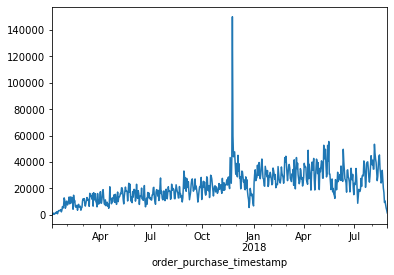

In [33]:
daily_demands = delivered['price'].resample('d').sum()
daily_demands.plot()

Revenues and demand seem to be trending over time, so need to account for non-stationarity in modelling and tests.

Something weird going on in the series in Nov-Dec 2017

We unfortunately cannot really do any annual seasonality with this short of a series. However, there seems to not be visibly notable seasonality in either case.

In [34]:
daily_by_category = delivered.groupby('product_category_name').resample('d')['price'].agg(['sum','count'])

In [35]:
category_revenues_wide = daily_by_category.reset_index().pivot(columns='product_category_name',
                                      index='order_purchase_timestamp',values='sum')
category_revenues_wide = category_revenues_wide.fillna(0)


<AxesSubplot:xlabel='product_category_name', ylabel='product_category_name'>

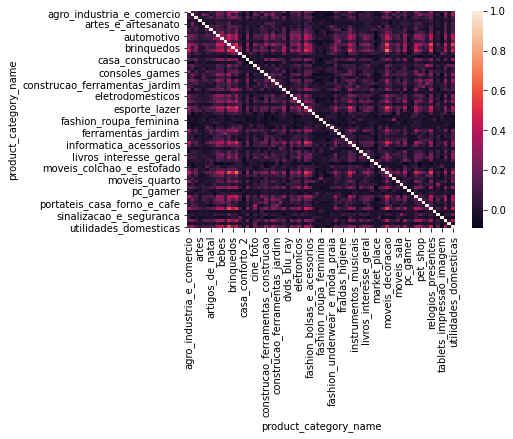

In [36]:
sns.heatmap(category_revenues_wide.corr())

There seems to be relatively low correlations across categories on the daily series.

<AxesSubplot:ylabel='Frequency'>

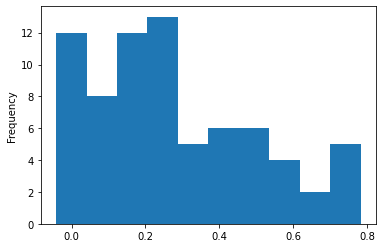

In [37]:
category_corrs_with_total = category_revenues_wide.apply(lambda x: np.corrcoef(daily_revenues, x)[0, 1])
category_corrs_with_total.plot(kind='hist')

Wide range of correlations with total sales for different items.

product_category_name,construcao_ferramentas_construcao,consoles_games,climatizacao,fashion_esporte,utilidades_domesticas
product_category_name,,,,,
construcao_ferramentas_construcao,1.000000,0.020820,0.023559,-0.047192,0.324317
consoles_games,0.020820,1.000000,-0.045135,0.023190,0.077400
climatizacao,0.023559,-0.045135,1.000000,0.016239,0.068238
fashion_esporte,-0.047192,0.023190,0.016239,1.000000,-0.046954
utilidades_domesticas,0.324317,0.077400,0.068238,-0.046954,1.000000


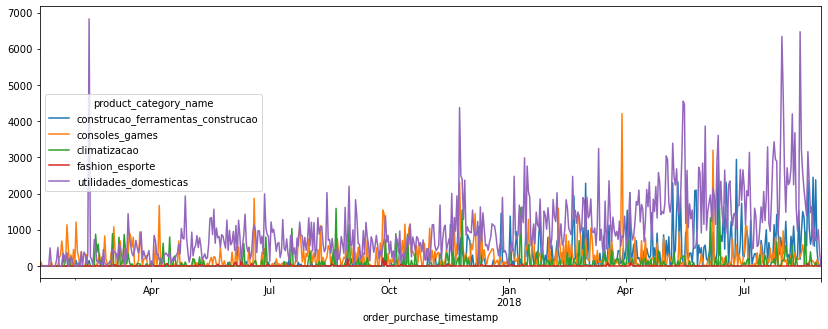

In [38]:
top5_cats = category_revenues_wide.count().sort_values().tail(5).index
category_revenues_wide[top5_cats].plot(figsize=(14, 5))
category_revenues_wide[top5_cats].corr()


<AxesSubplot:xlabel='order_purchase_timestamp'>

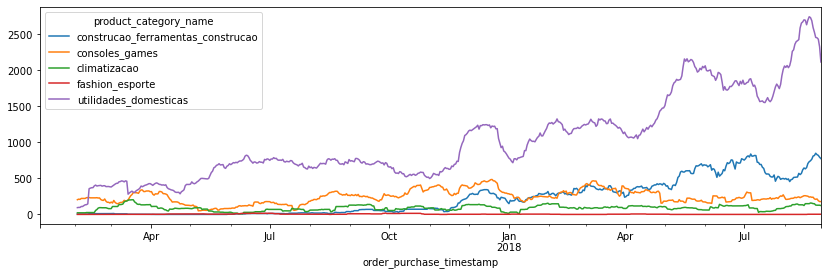

In [39]:
category_revenues_wide[top5_cats].rolling(30).mean().plot(figsize=(14, 4))

The overall takeaway from these plots seems to bee that there is a common component in the demand across different categories,
but strong individual variance across products.

One decent approach to model would be to first develop an aggregate model, whose outputs can be used as inputs toward the.

<AxesSubplot:>

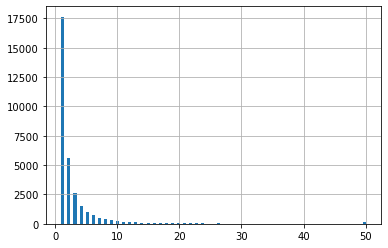

In [46]:
delivered.groupby('product_id')['price'].count().clip(0, 50).hist(bins=100)

We have on average very few total purchases per item, so item-specific product seems not feasible.

In [157]:
daily_by_category

sum  count
product_category_name     order_purchase_timestamp                
agro_industria_e_comercio 2017-01-23                  43.98      2
                          2017-01-24                   0.00      0
                          2017-01-25                   0.00      0
                          2017-01-26                   0.00      0
                          2017-01-27                   0.00      0
...                                                     ...    ...
utilidades_domesticas     2018-08-24                1037.23     18
                          2018-08-25                 699.69      5
                          2018-08-26                 725.50      9
                          2018-08-27                1004.19     13
                          2018-08-28                 383.39      8

[38837 rows x 2 columns]